In [1]:
# sentiment analysis: google vs. apple

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB


# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('./tweets.csv', encoding = "ISO-8859-1", names=["tweet", "product", "sentiment"], header=0)

In [4]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
df.info

<bound method DataFrame.info of                                                   tweet             product  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1     @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2     @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3     @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   
...                                                 ...                 ...   
9088                      Ipad everywhere. #SXSW {link}                iPad   
9089  Wave, buzz... RT @mention We interrupt your re...                 NaN   
9090  Google's Zeiger, a physician never reported po...                 NaN   
9091  Some Verizon iPhone customers complained their...                 NaN   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...                 NaN   

                   

## Clean data

In [6]:
# make sentiment numeric value
df.sentiment = df['sentiment'].map(lambda x: 1 if x == "Positive emotion" else x)
df.sentiment = df['sentiment'].map(lambda x: -1 if x == "Negative emotion" else x)
df.sentiment = df['sentiment'].map(lambda x: 0 if x == "No emotion toward brand or product" or x == "I can't tell" else x)

df['positive'] = df['sentiment'].map(lambda x: 1 if x == 1 else 0)
df['negative'] = df['sentiment'].map(lambda x: 1 if x == -1 else 0)
df['neutral'] = df['sentiment'].map(lambda x: 1 if x == 0 else 0)

In [7]:
# drop missing products
df.product = df['product'].map(lambda x: np.NaN if x == "NaN" else x)

df.dropna(subset=['product'], inplace=True)

In [8]:
df.shape

(3291, 6)

In [9]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [10]:
df['product'] = df['product'].map(lambda x: "apple" if x == "iPad" or\
                                  x == 'Apple' or\
                                  x == 'iPad or iPhone App ' or\
                                  x == 'iPhone' or\
                                  x == 'Other Apple product or service'
                                 else 'google')

In [11]:
df['product'].value_counts()

apple     1939
google    1352
Name: product, dtype: int64

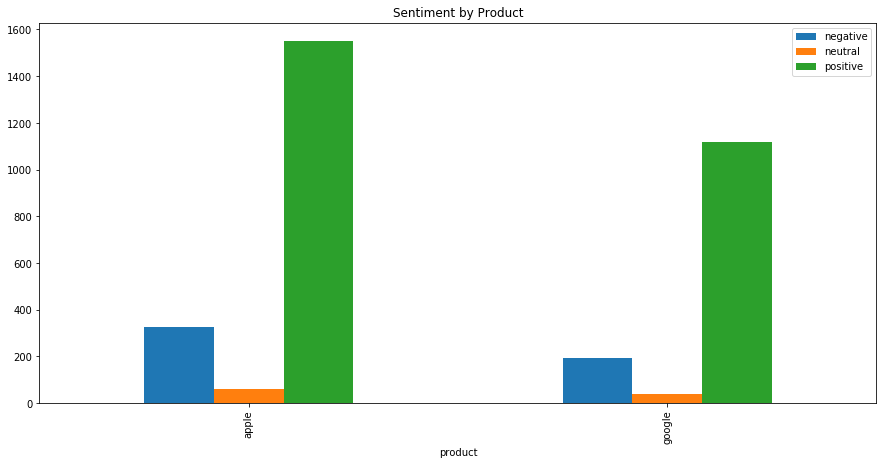

In [12]:
df.groupby(['product'])[['negative', 'neutral', 'positive']].sum().plot.bar(figsize=(15,7));
plt.title('Sentiment by Product');

In [13]:
apple = df[df['product'] == 'apple']
google = df[df['product'] == 'google']

## Feature Engineering

In [14]:
## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘']
sw_set = set(sw_list)

In [15]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed 

In [16]:
processed_data = list(map(process_tweet, df.iloc[:, 0]))

In [17]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

6056

In [18]:
lemmatizer = WordNetLemmatizer() 

lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [19]:
X_lem = lemmatized_output
# [' '.join(d) for d in processed_data]

y_lem = df.iloc[:, 2]

## Exploratory Data Analysis

In [20]:
df_freq_pos = df[df['sentiment']==1]
df_freq_neutral = df[df['sentiment']==0]
df_freq_neg = df[df['sentiment']==-1]

In [21]:
data_pos = df_freq_pos['tweet']
data_neutral = df_freq_neutral['tweet']
data_neg = df_freq_neg['tweet']

In [22]:
pros_pos = list(map(process_tweet, data_pos))
pros_neutral = list(map(process_tweet, data_neutral))
pros_neg = list(map(process_tweet, data_neg))

In [23]:
flat_pos = [item for sublist in pros_pos for item in sublist]
flat_neutral = [item for sublist in pros_neutral for item in sublist]
flat_neg = [item for sublist in pros_neg for item in sublist]

In [24]:
pos_freq = FreqDist(flat_pos)
neutral_freq = FreqDist(flat_neutral)
neg_freq = FreqDist(flat_neg)

In [25]:
pos_freq.most_common(20)

[('sxsw', 2788),
 ('mention', 1941),
 ('link', 1087),
 ('ipad', 918),
 ('apple', 856),
 ('rt', 832),
 ('google', 619),
 ('store', 497),
 ('iphone', 464),
 ('2', 459),
 ("'s", 442),
 ('quot', 412),
 ('app', 359),
 ('new', 318),
 ('austin', 265),
 ('ipad2', 186),
 ('amp', 184),
 ('android', 176),
 ('get', 144),
 ("n't", 141)]

In [26]:
neutral_freq.most_common(20)

[('sxsw', 109),
 ('mention', 53),
 ('link', 36),
 ('ipad', 35),
 ('apple', 32),
 ('google', 28),
 ('quot', 25),
 ('rt', 22),
 ('store', 20),
 ("'s", 18),
 ('iphone', 18),
 ("n't", 16),
 ('2', 11),
 ('new', 11),
 ('pop-up', 9),
 ('austin', 9),
 ('like', 9),
 ('circles', 8),
 ('app', 7),
 ('launch', 7)]

In [27]:
neg_freq.most_common(20)

[('sxsw', 532),
 ('mention', 284),
 ('ipad', 176),
 ('quot', 159),
 ('iphone', 149),
 ('google', 125),
 ('rt', 125),
 ('apple', 113),
 ('link', 87),
 ("n't", 77),
 ("'s", 71),
 ('2', 59),
 ('app', 54),
 ('store', 42),
 ('new', 39),
 ('like', 37),
 ('apps', 28),
 ('people', 28),
 ('circles', 25),
 ('social', 25)]

## Build Model

In [28]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<2632x4794 sparse matrix of type '<class 'numpy.float64'>'
	with 31071 stored elements in Compressed Sparse Row format>

In [29]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 11.805091185410335
Percentage of columns containing ZERO: 0.9975375279129307


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['tweet'])

In [31]:
df = pd.DataFrame(text_counts.todense(), columns = cv.get_feature_names())
df

,0,0 android,0 great,0 guys,0 just,0 tablet,0 tomorrow,000,000 come,000 downloads,...,zomg,zomg ipad,zomg mention,zone,zone right,zoom,zoom amp,zoom brushstroke,zzzs,zzzs iphone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0)

In [33]:
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [34]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [ ]:
#Preprocess data
df.tweet = df['tweet'].apply(preprocess_tweet_text)
# Split dataset into Train, Test

# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(df.iloc[:, 0]).ravel())
X = tf_vector.transform(np.array(df.iloc[:, 0]).ravel())
y = np.array(df.iloc[:, 2]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)

y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))